#  *The Eight Schools model illustration*

# Imports

In [1]:
!pip install torch pystan seaborn matplotlib pandas numpy

In [2]:
import torch
from torch.nn.functional import softplus
from torch.distributions import Normal, Cauchy

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    env = torch.cuda
    device = torch.device('cuda')
    print("Using GPU")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    env = torch
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [4]:
import sys
import time
import pandas as pd
import numpy as np
import random
np.random.seed(seed=0)
random.seed(0)

In [5]:
from aux import print2, tonumpy, tonumpy2, flatten_first_two_dims, parse_script_args

In [6]:
import losses
import utility_term_estimation
import optimal_decisions
import evaluation 

[Evaluation] Results of optimal_h_for_risk will be cached.


In [7]:
from importlib import reload  
reload(losses)
reload(evaluation)
reload(utility_term_estimation)
reload(optimal_decisions)

[Evaluation] Results of optimal_h_for_risk will be cached.


<module 'optimal_decisions' from '/home/local/user/Dropbox/prj_viLoss/NIPS2019Submission/code/optimal_decisions.py'>

# Configuration

In [8]:
args = parse_script_args() # arguments can be passed in the format of NAME1=FLOATVAL1,NAME2=[STRVAL2],NAME3=INTVAL3,...

parsing: <-f>


In [9]:
# optimization general parmeters
SEED = args.get("SEED", 123)
NITER  = 30001 # number of iterations - around 20k is advised
LR = 0.01

# number of samples used to approximate ELBO term
NSAMPLES = 11

In [10]:
# selected loss: tilted/squared/exptilted/expsquared
LOSS = "tilted" 
TILTED_Q = 0.2  # relevant only for tilted and exptilted

# loss-to-utility transformation (bigM: utility=M-loss / id: utility=-loss / expsquared=exptilted=1.0-loss)
UTIL =  "bigM" # for UTILITY_TERM==linearized both bigM and id are equivalent
M = 7.0 # ~90% percentile of losses for VI
GAMMA = 1.0/M # matters only for UTIL=exp; should be fixed manually to match a quantile

In [11]:
# constructing an approximation to the utility-dependent term:
UTILITY_TERM = "linearized" # vi/naive/linearized/jensen
# the utility-dependent term is multiplied by this value: 
# should be different from 1.0 only for UTILITY_TERM = "linearized"
UTILITY_TERM_SCALE = (1.0/M if "linear" in UTILITY_TERM else 1.0)

# how many samples of latent variables
NSAMPLES_UTILITY_TERM_THETA = 123
# how many samples of y for each latent variable
NSAMPLES_UTILITY_TERM_Y = 11

In [12]:
# Evaluation configuration

# how often to evaulate (=report losses and (optionally) gains)
EVAL_NITER = 1000

# Usually to evaluate risks we rely on Bayes estimators whereas for gains we use numerical optimization.
GAIN_OPTIMAL_H_NUMERICALLY = False # If set to False, Bayes estimators will be used for evaluation
RISK_OPTIMAL_H_NUMERICALLY = False # otherwise numerical (slow) optimization is used

# evaluation parameters (these numbers should be sufficently large 
# if we want to trust our evaluation):
#  number of samples of latent variables
EVAL_NSAMPLES_UTILITY_TERM_THETA = 10000
#  number of samples of y for each latent variable
EVAL_NSAMPLES_UTILITY_TERM_Y = 1
# parameters of the numerical optimization w.r.t. h used in evaluation
EVAL_MAX_NITER = 10000
EVAL_SGD_PREC = 0.0001

# Data

In [13]:
schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

# Model definition

In [14]:
def jacobian_softplus(x):
       return 1.0/(1.0 + torch.exp(-x))

    
def model_log_prob(data, mu, tau, theta):    
    y = torch.tensor(data["y"], dtype=torch.float32)
    sigma = torch.tensor(data["sigma"], dtype=torch.float32)
    taup = softplus(tau)
    
    lik = Normal(theta, sigma)
    prior_theta = Normal(mu, taup)
    prior_mu = Normal(0.0, 5.0)
    prior_tau = Cauchy(0.0, 5.0)  #half-Cauchy (=2*pdf of Cauchy)
    
    return lik.log_prob(y).sum() \
            + prior_theta.log_prob(theta).sum() \
            + prior_mu.log_prob(mu) \
            + torch.tensor(2.0, dtype=torch.float32).log()+prior_tau.log_prob(taup) \
            + torch.log(jacobian_softplus(tau))

## Sampling from predictive posterior distribution

In [15]:
def sample_predictive_y0(data, q_theta, nsamples_theta, nsamples_y):
    """ Returns a tensor with samples     
        (nsamples_y samples of y for each theta x 
         nsamples_theta samples of latent variables).
    """
    sigma = torch.tensor(data["sigma"], dtype=torch.float32)
    
    theta =  q_theta.rsample(torch.Size([nsamples_theta]))
    ys = Normal(theta, sigma).rsample(torch.Size([nsamples_y]))    
    return ys


def sample_predictive_y(data, q_theta, nsamples_theta, nsamples_y):
    """ Returns a tensor with samples (nsamples_y x nsamples_theta).
        Flattents the first two dimensions 
        (samples of y for different thetas) from sample_predictive_y0.
    """    
    ys = sample_predictive_y0(data, q_theta, nsamples_theta, nsamples_y)
    return flatten_first_two_dims(ys)

# Preparing losses, utilities and Bayes estimator

In [16]:
# include all (training) data points in utility-dependent term
utility_term_mask = torch.ones(schools_dat["J"]).type(env.ByteTensor) 

loss, optimal_h_bayes_estimator = losses.LossFactory(**globals()).create(LOSS)
print2("> <%s> loss: %s with (analytical/Bayes estimator) h: %s" % 
        (LOSS, loss.__name__, optimal_h_bayes_estimator.__name__))
        
u = losses.UtilityFactory(**globals()).create(UTIL, loss)
print2("> utility: %s" % u.__name__)            

[LossFactory] Configuration: TILTED_Q=0.2 LINEX_C=None
> <tilted> loss: tilted_loss_fixedq with (analytical/Bayes estimator) h: tilted_optimal_h_fixedq
[UtilityFactory] Configuration: M=10000.0 GAMMA=0.0001
> utility: ubigM


In [17]:
utility_term_factory = utility_term_estimation.UtilityAggregatorFactory()

# Evaluation

In [18]:
measures = evaluation.Measures(
                 torch.tensor(schools_dat["y"], dtype=torch.float32), 
                 loss, u, sample_predictive_y, 
                 optimal_h_bayes_estimator=optimal_h_bayes_estimator,
                 y_mask=utility_term_mask, # all data points
                 GAIN_OPTIMAL_H_NUMERICALLY = GAIN_OPTIMAL_H_NUMERICALLY,
                 RISK_OPTIMAL_H_NUMERICALLY = RISK_OPTIMAL_H_NUMERICALLY,
                 EVAL_NSAMPLES_UTILITY_TERM_THETA = EVAL_NSAMPLES_UTILITY_TERM_THETA,
                 EVAL_NSAMPLES_UTILITY_TERM_Y = EVAL_NSAMPLES_UTILITY_TERM_Y,
                 EVAL_MAX_NITER = EVAL_MAX_NITER,
                 EVAL_SGD_PREC = EVAL_SGD_PREC) 

[Evaluation] Configuration: y=torch.Size([8]) y_mask=torch.Size([8]) loss=tilted_loss_fixedq utility=ubigM sample_predictive_y=sample_predictive_y optimal_h_bayes_estimator=tilted_optimal_h_fixedq GAIN_OPTIMAL_H_NUMERICALLY=False RISK_OPTIMAL_H_NUMERICALLY=False EVAL_NSAMPLES_UTILITY_TERM_THETA=10000 EVAL_NSAMPLES_UTILITY_TERM_Y=1 EVAL_MAX_NITER=10000 EVAL_SGD_PREC=0.0001 EVAL_LR=0.01
[Evaluation] Results of optimal_h_for_gain will be cached.
[Evaluation] Results of optimal_h_for_risk will be cached.
[Evaluation] Results of sample_predictive_posterior will be cached.


# Standard mean-field VI

In [19]:
# intialization
torch.manual_seed(SEED)
np.random.seed(SEED)

q_mu_loc = torch.randn((1), requires_grad=True)
q_mu_scale = torch.ones((1), requires_grad=True)
q_tau_loc = torch.randn((1), requires_grad=True) 
q_tau_scale = torch.tensor((1.0), requires_grad=True)
q_theta_loc = torch.randn((schools_dat["J"]), requires_grad=True)
q_theta_scale = torch.ones((schools_dat["J"]), requires_grad=True)

In [20]:
optimizer = torch.optim.Adam([q_mu_loc, q_mu_scale, q_tau_loc, q_tau_scale, 
                                q_theta_loc, q_theta_scale], lr=LR)

In [21]:
start = time.time()
report = []
losses = []
trajectory_vi = {}
for i in range(NITER):    
    q_mu = Normal(q_mu_loc, softplus(q_mu_scale))    
    q_tau = Normal(q_tau_loc, softplus(q_tau_scale))    
    q_theta = Normal(q_theta_loc, softplus(q_theta_scale))    
    
    elbo = 0.0
    for _ in range(NSAMPLES):
        mu =  q_mu.rsample()               
        tau =  q_tau.rsample()               
        theta =  q_theta.rsample()               

        elbo += model_log_prob(schools_dat, mu, tau, theta) \
                -q_mu.log_prob(mu).sum() -q_tau.log_prob(tau).sum() -q_theta.log_prob(theta).sum()
    elbo = elbo/NSAMPLES            
    
    optimizer.zero_grad()    
    (-elbo).backward()
    optimizer.step()

    if i%EVAL_NITER==0 or i==NITER-1:
        
        # store losses
        ys = sample_predictive_y(schools_dat, q_theta, nsamples_theta=100, nsamples_y=1)        
        h = optimal_h_bayes_estimator(ys)
        losses.append(loss(h,ys))        
        
        # store trajectories of posteriors
        trajectory_vi.setdefault("qmu_loc",[]).append(tonumpy2(q_mu_loc)) 
        trajectory_vi.setdefault("qmu_scale",[]).append(tonumpy2(softplus(q_mu_scale)))         
        trajectory_vi.setdefault("qtau_loc",[]).append(tonumpy2(softplus(q_tau_loc))) 
        trajectory_vi.setdefault("qtau_scale",[]).append(tonumpy2(softplus(q_tau_scale))) 
        trajectory_vi.setdefault("qtheta_loc",[]).append(tonumpy2(q_theta_loc) ) 
        trajectory_vi.setdefault("qtheta_scale",[]).append(tonumpy2(softplus(q_theta_scale)))                 
        
        print("iter/epoch %i. evaluating..." % i)        
        rmse = (tonumpy(q_theta_loc)-np.array(schools_dat['y']))**2
        training_rmse = rmse.mean()
        r = (time.time()-start, "VI", SEED, i, elbo.item(), 
                 training_rmse, 
                 measures.qrisk(schools_dat, q_theta).item(), 
                 measures.empirical_risk(schools_dat, q_theta).item(),
                 measures.qgain(schools_dat, q_theta).item(), 
                 measures.empirical_gain(schools_dat, q_theta).item(),
                 softplus(q_tau_loc).item(), softplus(q_tau_scale).item(),
                 q_mu_loc.item(), softplus(q_mu_scale).item() )
        report.append(r)         
        print2(("""[%.1fs][%s][%s][%s] elbo: %.2f;  training rmse:%.4f  qRisk:%.4f eRisk:%.4f 
                  qGain:%.4f eGain:%.4f""" % (r[:10])) + " q_tau_loc: %.2f" % softplus(q_tau_loc).item())     
        
        LOSSSTR = (("%s%s" % (LOSS, TILTED_Q)) if "tilted" in LOSS else LOSS)
        OUT = "8s_VI_%i_%s_%s" % (SEED, LOSSSTR, UTIL)
        pd.DataFrame(report).to_csv(OUT+".csv", header=False, index=False)         

iter/epoch 0. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([-13.0958,  -8.6089, -14.9901,  -9.1397,  -8.6549, -10.0058,  -8.2463,
        -15.2858])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([-13.0958,  -8.6089, -14.9901,  -9.1397,  -8.6549, -10.0058,  -8.2463,
        -15.2858])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusi

[133.4s][VI][123][6000] elbo: -36.28;  training rmse:166.4952  qRisk:3.5394 eRisk:3.8350 
                  qGain:9996.4619 eGain:9996.1641 q_tau_loc: 1.87
iter/epoch 7000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([-11.9972,  -7.9554, -13.3809,  -8.8559,  -7.5898,  -8.8922,  -7.8123,
        -14.6879])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([-11.9972,  -7.9554, -13.3809,  -8.8559,  -7.5898,  -8.8922,  -7.8123,
        -14.68

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[268.8s][VI][123][13000] elbo: -33.29;  training rmse:98.3383  qRisk:3.6715 eRisk:3.0980 
                  qGain:9996.3301 eGain:9996.9014 q_tau_loc: 4.74
iter/epoch 14000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([ -6.9447,  -4.5380, -10.4784,  -5.2000,  -5.4525,  -6.1779,  -2.3430,
        -11.2592])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[

[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([ -6.1318,  -4.5900, -10.7808,  -5.5939,  -5.6637,  -6.8596,  -1.8017,
        -10.9335])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[421.1s][VI][123][20000] elbo: -33.50;  training rmse:84.0558  qRisk:3.7908 eRisk:3.0589 
                  qGain:9996.2109 eGain:9996.9414 q_tau_loc: 5.89
iter/epoch 21000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([ -6.0145,  -3.9396, -10.3612,  -5.2241,  -5.8526,  -6.5086,  -2.0282,
        -10.3741])
[Evaluation] Reusing previous result of sample_predictive_post

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([ -6.2147,  -4.3280, -11.0117,  -5.5066,  -5.9970,  -6.7364,  -1.6737,
        -11.3295])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[600.5s][VI][123][27000] elbo: -33.67;  training rmse:84.2931  qRisk:3.7706 eRisk:3.0699 
                  qGain:9996.2324 eGain:9996.9307 q_tau_loc: 5.97
iter/epoch 28000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_ris

In [22]:
# Save results for later
report_vi = report
q_mu_vi = q_mu
q_tau_vi = q_tau
q_theta_vi = q_theta  

# LCVI using joint optimization of decisions and parameters

In [23]:
utility_term = utility_term_factory.create(UTILITY_TERM)
print2("> utility_term: %s" % utility_term.__name__)  

[UtilityAggregatorFactory] creating linearized (a=None, b=None)
> utility_term: utility_term_linearized


In [24]:
# intialization
torch.manual_seed(SEED)
np.random.seed(SEED)

q_mu_loc = torch.randn((1), requires_grad=True)
q_mu_scale = torch.ones((1), requires_grad=True)
q_tau_loc = torch.randn((1), requires_grad=True) 
q_tau_scale = torch.tensor((1.0), requires_grad=True)
q_theta_loc = torch.randn((schools_dat["J"]), requires_grad=True)
q_theta_scale = torch.ones((schools_dat["J"]), requires_grad=True)

h = torch.randn((schools_dat['J']), requires_grad=True)

In [25]:
optimizer = torch.optim.Adam([q_mu_loc, q_mu_scale, q_tau_loc, q_tau_scale, 
                              q_theta_loc, q_theta_scale, h], lr=LR) 

In [26]:
start = time.time()
report = []
trajectory_lcvi = {}
for i in range(NITER):    

    q_mu = Normal(q_mu_loc, softplus(q_mu_scale))    
    q_tau = Normal(q_tau_loc, softplus(q_tau_scale))    
    q_theta = Normal(q_theta_loc, softplus(q_theta_scale))    
    
    elbo = 0.0
    for _ in range(NSAMPLES):
        mu =  q_mu.rsample()               
        tau =  q_tau.rsample()               
        theta =  q_theta.rsample()               

        elbo += model_log_prob(schools_dat, mu, tau, theta) \
                -q_mu.log_prob(mu).sum() -q_tau.log_prob(tau).sum() -q_theta.log_prob(theta).sum()
    elbo = elbo/NSAMPLES    
                             
    ys = sample_predictive_y0(schools_dat, q_theta, 
                                    nsamples_theta=NSAMPLES_UTILITY_TERM_THETA,
                                    nsamples_y=NSAMPLES_UTILITY_TERM_Y)        
      
    optimizer.zero_grad()            
    objective = -elbo -utility_term(u(h,ys), utility_term_mask)*UTILITY_TERM_SCALE
    objective.backward(retain_graph=False)
    optimizer.step()
        
    if i%EVAL_NITER==0 or i==NITER-1: #report results
        
        #store trajectories of posteriors
        trajectory_lcvi.setdefault("qmu_loc",[]).append(tonumpy2(q_mu_loc)) 
        trajectory_lcvi.setdefault("qmu_scale",[]).append(tonumpy2(softplus(q_mu_scale)))         
        trajectory_lcvi.setdefault("qtau_loc",[]).append(tonumpy2(softplus(q_tau_loc))) 
        trajectory_lcvi.setdefault("qtau_scale",[]).append(tonumpy2(softplus(q_tau_scale))) 
        trajectory_lcvi.setdefault("qtheta_loc",[]).append(tonumpy2(q_theta_loc)) 
        trajectory_lcvi.setdefault("qtheta_scale",[]).append(tonumpy2(softplus(q_theta_scale)))         
                
        print("iter/epoch %i. evaluating..." % i)
        rmse = (tonumpy(q_theta_loc)-np.array(schools_dat['y']))**2
        training_rmse = rmse.mean()
        r = (time.time()-start, utility_term.__name__, SEED, i, elbo.item(), 
                 training_rmse, 
                 measures.qrisk(schools_dat, q_theta).item(), 
                 measures.empirical_risk(schools_dat, q_theta).item(),
                 measures.qgain(schools_dat, q_theta).item(), 
                 measures.empirical_gain(schools_dat, q_theta).item(),
                 softplus(q_tau_loc).item(), softplus(q_tau_scale).item(),
                 q_mu_loc.item(), softplus(q_mu_scale).item() )
        report.append(r)    
        print2(("""[%.1fs][%s][%s][%s] elbo: %.2f;  training rmse:%.4f  qRisk:%.4f eRisk:%.4f 
                  qGain:%.4f eGain:%.4f""" % (r[:10])) + " q_tau_loc: %.2f" % softplus(q_tau_loc).item())        
        
        LOSSSTR = (("%s%s" % (LOSS, TILTED_Q)) if "tilted" in LOSS else LOSS)
        OUT = "8s_LCVI_%s%s_%i_%s_%s" % (UTILITY_TERM, UTILITY_TERM_SCALE, SEED, LOSSSTR, UTIL)
        pd.DataFrame(report).to_csv(OUT+".csv", header=False, index=False)
        

iter/epoch 0. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([-13.0438,  -8.6459, -14.9408,  -9.1263,  -8.6445,  -9.9416,  -8.2413,
        -15.2712])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([-13.0438,  -8.6459, -14.9408,  -9.1263,  -8.6445,  -9.9416,  -8.2413,
        -15.2712])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusi

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[175.6s][utility_term_linearized][123][6000] elbo: -35.84;  training rmse:164.0387  qRisk:3.5352 eRisk:3.8158 
                  qGain:9996.4678 eGain:9996.1836 q_tau_loc: 2.07
iter/epoch 7000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([-12.1126,  -7.9064, -13.0640,  -8.7992,  -7.3780,  -8.8676,  -7.4684,
        -14.7972])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result 

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([ -7.7496,  -4.4785, -10.5992,  -5.5688,  -5.2251,  -6.4210,  -2.8327,
        -11.1593])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[386.8s][utility_term_linearized][123][13000] elbo: -33.56;  training rmse:97.9067  qRisk:3.7014 eRisk:3.1009 
                  qGain:9996.3008 eGain:9996.8994 q_tau_loc: 4.52
iter/epoch 14000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([ -6.8880,  -3.9629, -10.2802,  -5.4603,  -5.1944,  -6.1231,  -

[Evaluation:optimal_h_for_risk] h=tensor([ -6.4957,  -4.0899, -10.2722,  -4.8588,  -4.9007,  -6.2632,  -2.2511,
        -10.8588])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([ -6.4957,  -4.0899, -10.2722,  -4.8588,  -4.9007,  -6.2632,  -2.2511,
        -10.8588])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[582.9s][utility_term_linearized][123][20000] elbo: -34.14;  training rmse:91.1845  qRisk:3.7070 eRisk:2.9998 
                  qGain:9996.2959 eGain:9997.0010 q_tau_loc: 5.11
iter/epoch 21000. evaluating...


iter/epoch 27000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([ -6.5831,  -3.6629, -10.0007,  -5.1964,  -5.2285,  -5.9465,  -2.1171,
        -10.3039])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([ -6.5831,  -3.6629, -10.0007,  -5.1964,  -5.2285,  -5.9465,  -2.1171,
        -10.3039])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] R

In [27]:
# Save results for later
report_lcvi = report
q_mu_lcvi = q_mu
q_tau_lcvi = q_tau
q_theta_lcvi = q_theta

# LCVI-EM

In [28]:
# Configuration of M-step

# finding optimal h:
#  bayes - use Bayes estimator / num-gain - optimize numerically gain / 
#  num-util - optimize numerically a selected approximation to the utility-dependent term.
FIND_H = "bayes" # Bayes estimator can be used only when available (for certain losses)

# choose an approximation to the utility-dependent term, 
#  by default == UTILITY_TERM (the same as for lambdas)
H_UTILITY_AGGREGATOR = UTILITY_TERM
# respectively, the number of theta and y samples used when optimizing for h
H_NSAMPLES_UTILITY_TERM_THETA = NSAMPLES_UTILITY_TERM_THETA
H_NSAMPLES_UTILITY_TERM_Y = NSAMPLES_UTILITY_TERM_Y

# parameters of the numerical optimizer used to find the optimal h
H_NUMERICAL_MAX_NITER = 10000
H_NUMERICAL_MAX_NITER_TOL = 0.0001
H_NUMERICAL_MAX_NITER_TOL_GOAL = -1
H_NUMERICAL_LR =  0.01
H_NUMERICAL_OPT_SCIPY = False
H_NUMERICAL_START_FROM_PREVIOUS = False

In [29]:
h_utility_term = utility_term_factory.create(H_UTILITY_AGGREGATOR)
print2("> decision optimizer's utility_term: %s (used only with numerical optimizers)" % h_utility_term.__name__)  

# prepares an optimizer for M-step
decision_maker =  optimal_decisions.HOptimizerFactory(**globals()).create(FIND_H, u=u, 
                                                    optimal_h_bayes_estimator=optimal_h_bayes_estimator, 
                                                    utility_aggregator=h_utility_term)
print2("> decision_maker: %s" % decision_maker.__name__)  

[UtilityAggregatorFactory] creating linearized (a=None, b=None)
> decision optimizer's utility_term: utility_term_linearized (used only with numerical optimizers)
[HOptimizerFactory] Configuration: H_NSAMPLES_UTILITY_TERM_THETA=123 H_NSAMPLES_UTILITY_TERM_Y=11 H_NUMERICAL_MAX_NITER=10000 H_NUMERICAL_MAX_NITER_TOL=0.0001 H_NUMERICAL_MAX_NITER_TOL_GOAL=-1 H_NUMERICAL_LR=0.01 H_NUMERICAL_START_FROM_PREVIOUS=False sample_predictive_y0=sample_predictive_y0
[HOptimizerFactory] Choosing PyTorch numerical optimization.
> decision_maker: optimize_h_with_bayes_estimator


In [30]:
utility_term = utility_term_factory.create(UTILITY_TERM)
print2("> utility_term: %s" % utility_term.__name__)  

[UtilityAggregatorFactory] creating linearized (a=None, b=None)
> utility_term: utility_term_linearized


In [31]:
# intialization
torch.manual_seed(SEED)
np.random.seed(SEED)

q_mu_loc = torch.randn((1), requires_grad=True)
q_mu_scale = torch.ones((1), requires_grad=True)
q_tau_loc = torch.randn((1), requires_grad=True) 
q_tau_scale = torch.tensor((1.0), requires_grad=True)
q_theta_loc = torch.randn((schools_dat["J"]), requires_grad=True)
q_theta_scale = torch.ones((schools_dat["J"]), requires_grad=True)

In [32]:
optimizer = torch.optim.Adam([q_mu_loc, q_mu_scale, q_tau_loc, q_tau_scale, 
                              q_theta_loc, q_theta_scale], lr=LR) 

In [33]:
start = time.time()
report = []
trajectory_lcvi = {}
for i in range(NITER):  
  
    q_mu = Normal(q_mu_loc, softplus(q_mu_scale))    
    q_tau = Normal(q_tau_loc, softplus(q_tau_scale))    
    q_theta = Normal(q_theta_loc, softplus(q_theta_scale))    

    elbo = 0.0
    for _ in range(NSAMPLES):
        mu =  q_mu.rsample()               
        tau =  q_tau.rsample()               
        theta =  q_theta.rsample()               

        elbo += model_log_prob(schools_dat, mu, tau, theta) \
                -q_mu.log_prob(mu).sum() -q_tau.log_prob(tau).sum() -q_theta.log_prob(theta).sum()
    elbo = elbo/NSAMPLES    

    h = decision_maker(schools_dat, q_theta)  
    ys = sample_predictive_y0(schools_dat, q_theta, 
                                    nsamples_theta=NSAMPLES_UTILITY_TERM_THETA,
                                    nsamples_y=NSAMPLES_UTILITY_TERM_Y)  
                             
    optimizer.zero_grad()            
    objective = -elbo -utility_term(u(h,ys), utility_term_mask)*UTILITY_TERM_SCALE
    objective.backward(retain_graph=False)
    optimizer.step()
        
    if i%EVAL_NITER==0 or i==NITER-1: #report results
        
        #store trajectories of posteriors
        trajectory_lcvi.setdefault("qmu_loc",[]).append(tonumpy2(q_mu_loc)) 
        trajectory_lcvi.setdefault("qmu_scale",[]).append(tonumpy2(softplus(q_mu_scale)))         
        trajectory_lcvi.setdefault("qtau_loc",[]).append(tonumpy2(softplus(q_tau_loc))) 
        trajectory_lcvi.setdefault("qtau_scale",[]).append(tonumpy2(softplus(q_tau_scale))) 
        trajectory_lcvi.setdefault("qtheta_loc",[]).append(tonumpy2(q_theta_loc)) 
        trajectory_lcvi.setdefault("qtheta_scale",[]).append(tonumpy2(softplus(q_theta_scale)))         
                
        print("iter/epoch %i. evaluating..." % i)
        rmse = (tonumpy(q_theta_loc)-np.array(schools_dat['y']))**2
        training_rmse = rmse.mean()
        r = (time.time()-start, utility_term.__name__, SEED, i, elbo.item(), 
                 training_rmse, 
                 measures.qrisk(schools_dat, q_theta).item(), 
                 measures.empirical_risk(schools_dat, q_theta).item(),
                 measures.qgain(schools_dat, q_theta).item(), 
                 measures.empirical_gain(schools_dat, q_theta).item(),
                 softplus(q_tau_loc).item(), softplus(q_tau_scale).item(),
                 q_mu_loc.item(), softplus(q_mu_scale).item() )
        report.append(r)    
        print2(("""[%.1fs][%s][%s][%s] elbo: %.2f;  training rmse:%.4f  qRisk:%.4f eRisk:%.4f 
                  qGain:%.4f eGain:%.4f""" % (r[:10])) + " q_tau_loc: %.2f" % softplus(q_tau_loc).item())

iter/epoch 0. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([-13.0490,  -8.6718, -14.7943,  -9.1691,  -8.4734,  -9.8902,  -8.2688,
        -15.2550])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([-13.0490,  -8.6718, -14.7943,  -9.1691,  -8.4734,  -9.8902,  -8.2688,
        -15.2550])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusi

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[180.3s][utility_term_linearized][123][6000] elbo: -37.85;  training rmse:171.9884  qRisk:3.5284 eRisk:3.9137 
                  qGain:9996.4756 eGain:9996.0859 q_tau_loc: 1.66
iter/epoch 7000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([-12.7192,  -8.4289, -13.7710,  -9.0442,  -7.6208,  -9.1418,  -8.2038,
        -15.1642])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result 

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([ -9.0371,  -5.3107, -11.0729,  -6.3310,  -5.8939,  -6.7714,  -4.3990,
        -12.1453])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[367.7s][utility_term_linearized][123][13000] elbo: -33.91;  training rmse:115.8534  qRisk:3.5933 eRisk:3.2740 
                  qGain:9996.4092 eGain:9996.7266 q_tau_loc: 3.70
iter/epoch 14000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([ -8.1260,  -5.2403, -10.5449,  -6.0057,  -5.2634,  -6.6504,  

[Evaluation:optimal_h_for_risk] h=tensor([ -6.4535,  -4.0074, -10.2566,  -5.1880,  -4.7405,  -6.0711,  -2.3264,
        -10.8356])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([ -6.4535,  -4.0074, -10.2566,  -5.1880,  -4.7405,  -6.0711,  -2.3264,
        -10.8356])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[553.7s][utility_term_linearized][123][20000] elbo: -33.41;  training rmse:90.5744  qRisk:3.7047 eRisk:2.9970 
                  qGain:9996.2979 eGain:9997.0029 q_tau_loc: 4.98
iter/epoch 21000. evaluating...


iter/epoch 27000. evaluating...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([ -6.5381,  -4.0015,  -9.8223,  -5.2576,  -5.0228,  -5.9074,  -2.3112,
        -11.0218])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([ -6.5381,  -4.0015,  -9.8223,  -5.2576,  -5.0228,  -5.9074,  -2.3112,
        -11.0218])
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] R

In [34]:
# Save results for later
report_lcviem = report
q_mu_lcviem = q_mu
q_tau_lcviem = q_tau
q_theta_lcviem = q_theta
trajectory_lcviem = trajectory_lcvi 

# True posteriors using HMC (STAN)

In [35]:
import pystan
import numpy as np
import matplotlib.pyplot as plt

schools_code = """
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
    real theta[J];
    real mu;
    real<lower=0> tau;    
}
model {
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);    
}
"""

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_713ed586722beb79bd4de3f80f8c6a56 NOW.


Inference for Stan model: anon_model_713ed586722beb79bd4de3f80f8c6a56.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    6.0    0.43   5.55   -3.5   2.38    5.3   8.61  18.69    169   1.02
theta[2]   4.71    0.28   4.69  -4.91   1.78   4.58   7.47  13.95    290    1.0
theta[3]   3.57    0.32   5.14  -8.31   0.75   3.61   6.43  13.77    264   1.01
theta[4]   4.46    0.28   4.84   -5.3   1.47    4.5   7.02  14.21    308   1.01
theta[5]   3.52    0.31    4.5  -6.94   0.86   3.84   6.14  12.78    212   1.01
theta[6]   4.01    0.32   4.82  -6.54   1.13   4.37   6.71  13.56    222   1.01
theta[7]   6.27    0.38   5.08  -2.45   2.79   5.77   8.93  18.08    175   1.01
theta[8]   4.41     0.3   5.47  -6.32   1.34   4.47   7.54  15.21    331   1.01
mu         4.17    0.29   3.22  -2.11    1.9   4.41   6.13  11.84    123   1.02
tau        3.7

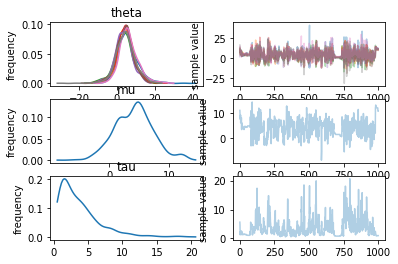

In [36]:
#HMC sampling
sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=500, chains=4)

print(fit)
fit.plot()
plt.show()

## STAN VI (sanity check)

In [37]:
fitvi = sm.vb(data=schools_dat, iter=10000000, tol_rel_obj=0.00001)

print(fitvi["args"])
pd.DataFrame(np.array(fitvi["sampler_params"]).T).rename(
    columns=dict(enumerate(fitvi["sampler_param_names"]))).describe()

{'random_seed': '1806341205', 'chain_id': 1, 'init': b'random', 'init_radius': 2.0, 'enable_random_init': False, 'append_samples': False, 'sample_file': b'/tmp/tmpjudv1kcm/output.csv', 'method': 'VARIATIONAL', 'iter': 10000000, 'grad_samples': 1, 'elbo_samples': 100, 'eval_elbo': 100, 'output_samples': 1000, 'eta': 1.0, 'adapt_engaged': True, 'adapt_iter': 50, 'tol_rel_obj': 1e-05, 'algorithm': 'MEANFIELD'}


,theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],theta[7],theta[8],mu,tau,lp__
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,7.391367,5.246821,3.206795,4.511000,2.177382,3.273271,8.276831,4.881115,3.931394,6.997848,0.0
std,6.271579,5.772884,6.270751,5.864545,5.420211,5.910166,5.608584,6.443861,2.241935,1.910618,0.0
min,-12.408840,-13.063944,-15.487371,-15.267336,-16.324716,-15.309978,-11.452596,-13.712211,-4.124626,3.360214,0.0
25%,3.270350,1.199679,-1.226692,0.761259,-1.413637,-0.626583,4.514490,0.346908,2.462720,5.614686,0.0
50%,7.337035,5.341832,3.110907,4.596265,2.350031,3.267723,8.119054,4.996578,3.997287,6.699120,0.0
75%,11.449341,9.301512,7.451851,8.746758,5.959659,7.085906,11.879786,9.213586,5.455398,7.998050,0.0
max,26.913641,20.459659,22.575433,22.467692,18.243054,22.030136,32.138789,25.629749,11.479826,15.537621,0.0


In [38]:
# Comparison against STAN VI
print("\n=============Our VI================")
print( pd.DataFrame( list(zip(tonumpy(q_theta_loc), tonumpy(softplus(q_theta_scale)))) + \
 [(q_mu_loc.item(), softplus(q_mu_scale).item())]+[(softplus(q_tau_loc).item(), (softplus(q_tau_scale)).item())] ).rename(columns={0: "mean", 1: "sd"}).transpose() )

print("\n============STAN VI================")
print( pd.DataFrame(np.array(fitvi["sampler_params"]).T).rename(
    columns=dict(enumerate(fitvi["sampler_param_names"]))).describe().transpose()[["mean", "std"]].transpose() )


=============Our VI================
             0         1         2         3         4         5         6  \
mean  6.405445  5.100568  3.809619  4.745933  3.174557  3.886571  6.887158   
sd    4.424639  4.177079  4.295655  4.262319  4.036857  4.212780  4.177432   

             7         8         9  
mean  4.910530  4.380007  4.980322  
sd    4.558775  1.579636  1.041482  

============STAN VI================
      theta[1]  theta[2]  theta[3]  theta[4]  theta[5]  theta[6]  theta[7]  \
mean  7.391367  5.246821  3.206795  4.511000  2.177382  3.273271  8.276831   
std   6.271579  5.772884  6.270751  5.864545  5.420211  5.910166  5.608584   

      theta[8]        mu       tau  lp__  
mean  4.881115  3.931394  6.997848   0.0  
std   6.443861  2.241935  1.910618   0.0  


# Plots

In [39]:
from aux_plt import *
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [40]:
# Decision maker: important to set the right one! Default: use Bayes estimator.
optimal_h = optimal_h_bayes_estimator 

## PDFs and CDF of losses for (converged) VI

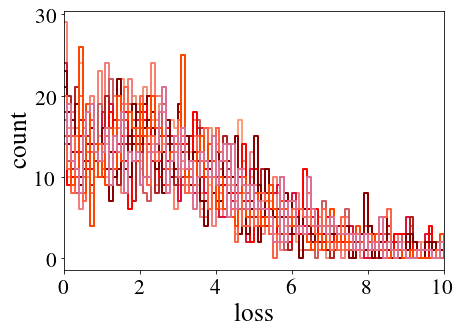

In [41]:
start_plotting(cmbright=False, font_size=17*1.5)    
epochs = pd.DataFrame(report)[3]
bins = np.arange(0, 20, 0.1)
for epoch, losses1, c in zip(epochs, losses, REDS):
    #if epoch not in [200,1000,2000,2600]: continue
    count, edges = np.histogram(tonumpy(losses1.view(-1)), bins=bins)
    plt.step(edges[:-1], count, where='post', label="epoch: %s" % epoch, color=c, lw=2)    
    #sns.kdeplot(tonumpy(losses1.view(-1)), label="epoch: %s" % epoch, gridsize=1000, color=c, lw=2)
#plt.legend()    
plt.xlim(0,10);
plt.xlabel("loss")
plt.ylabel("count")
plt.show()

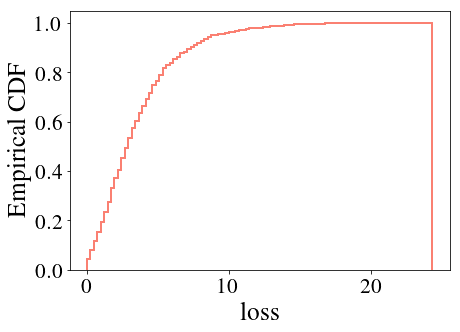

,percentile,value
0,1,0.0161
1,5,0.3165
2,10,0.5956
3,20,1.2925
4,30,1.8443
5,40,2.3853
6,50,2.9892
7,60,3.6060
8,70,4.4989
9,80,5.4279


In [42]:
losses1 = tonumpy(losses[-1].view(-1)) # For converged case

start_plotting(cmbright=False, font_size=17*1.5)    
n, bins, patches = plt.hist(losses1, 100, density=True, histtype='step', 
                            cumulative=True, label='Empirical', lw=2, color="salmon")
plt.xlabel("loss")
plt.ylabel("Empirical CDF")
#plt.xlim(0,5)
plt.show()

percentiles = [1,5,10,20,30,40,50,60,70,80,90,95,99]
loss_values = np.percentile(losses1, percentiles)
#print("percentiles=%s => \nloss_threshold_values=[%s]" % (percentiles, ", ".join(map(str, np.round(loss_values,4)))))
pd.DataFrame(zip(percentiles,  np.round(loss_values,4))).rename(columns={0: "percentile", 1: "value"})

## Convergence plots

In [43]:
COLS = dict(enumerate("t, utility_term, SEED, epoch, elbo, training_rmse, training_qrisk, training_erisk, training_qgain, training_egain".split(", ")))
report_vi_df = pd.DataFrame(report_vi).rename(columns=COLS)
report_lcvi_df = pd.DataFrame(report_lcvi).rename(columns=COLS)
report_lcviem_df = pd.DataFrame(report_lcviem).rename(columns=COLS)

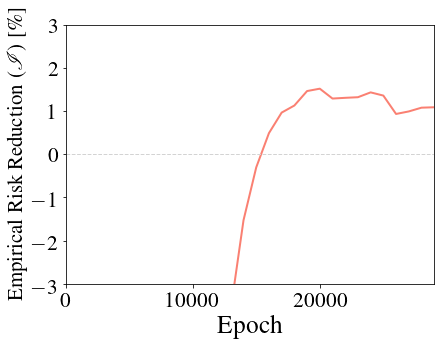

In [44]:
ER_VI = np.array(report_vi_df["training_erisk"])[-1]
report_lcvi_df["improvement"] =  100*(ER_VI-np.array(report_lcvi_df["training_erisk"]))/ER_VI

start_plotting(left=0.15, font_size=17*1.5, cmbright=False)
plt.plot(report_lcvi_df.epoch, running_mean(report_lcvi_df.improvement,7), lw=2, color="salmon")
plt.xlabel("Epoch");
plt.ylabel("Empirical Risk Reduction ($\mathcal{I}$) [\%]", fontsize=21)
plt.xlim(0, 29000)
plt.ylim(-3,3)
plt.axhline(0, color="lightgray", ls="--", lw=1)
plt.grid(False);
plt.savefig("8schools_improvement_iterations.pdf")
plt.show()

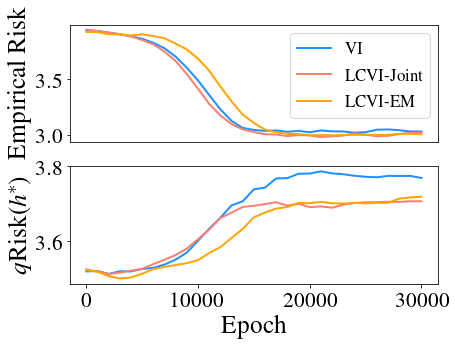

In [55]:
start_plotting(left=0.15, font_size=17*1.5, cmbright=False)

ax1 = plt.subplot(211)

plt.plot(report_vi_df.epoch, running_mean(report_vi_df.training_erisk), 
         color="dodgerblue", label="VI", lw=2);
plt.plot(report_lcvi_df.epoch, running_mean(report_lcvi_df.training_erisk), 
         color="salmon", label="LCVI-Joint", lw=2);
plt.plot(report_lcviem_df.epoch, running_mean(report_lcviem_df.training_erisk), 
         color="orange", label="LCVI-EM", lw=2);
plt.ylabel(r"Empirical Risk");
plt.legend(loc=1, fontsize=17);
ax1.set_xticks([],[])

ax2 = plt.subplot(212)

plt.plot(report_vi_df.epoch, running_mean(report_vi_df.training_qrisk), 
         color="dodgerblue", label="VI", lw=2);
plt.plot(report_lcvi_df.epoch, running_mean(report_lcvi_df.training_qrisk), 
         color="salmon", label="LCVI-Joint", lw=2);
plt.plot(report_lcviem_df.epoch, running_mean(report_lcviem_df.training_qrisk), 
         color="orange", label="LCVI-EM", lw=2);
plt.ylabel(r"$q$Risk($h^*$)");

plt.xlabel("Epoch");
plt.grid(False);
plt.savefig("8schools_loss_iterations.pdf")
plt.show();

## Parameter posteriors

### Illustration

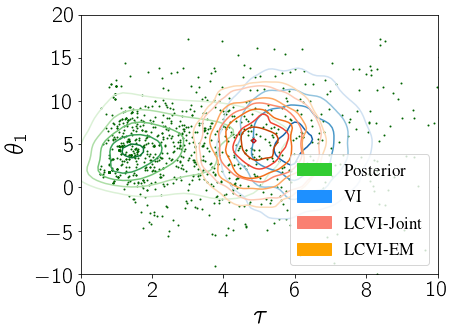

In [46]:
nsamples = 10000
theta_no = 1
n_levels = 4

start_plotting(font_size=17*1.5, left=0.175)
label_patches = []

x, y = (fit.extract()["tau"]), fit.extract()["theta"][:,theta_no]
sns.kdeplot(x, y, n_levels=int(n_levels*1.3), shade=False, cmap="Greens");
label_patches.append(mpatches.Patch(color="limegreen",label="Posterior")) #sns.color_palette("Greens")[2]
plt.scatter(x, y, s=1, color="darkgreen")

tau = np.array([softplus(q_tau_vi.sample()).item() for _ in range(nsamples)])
theta = np.array([q_theta_vi.sample()[theta_no].item() for _ in range(nsamples)])
sns.kdeplot(tau, theta, n_levels=n_levels, shade=False, cmap="Blues")
label_patches.append(mpatches.Patch(color="dodgerblue",label="VI")) #sns.color_palette("Blues")[2]

tau = np.array([softplus(q_tau_lcvi.sample()).item() for _ in range(nsamples)])
theta = np.array([q_theta_lcvi.sample()[theta_no].item() for _ in range(nsamples)])
sns.kdeplot(tau, theta, n_levels=n_levels, shade=False, cmap="Reds")
label_patches.append(mpatches.Patch(color="salmon",label="LCVI-Joint")) #sns.color_palette("Reds")[2]

tau = np.array([softplus(q_tau_lcviem.sample()).item() for _ in range(nsamples)])
theta = np.array([q_theta_lcviem.sample()[theta_no].item() for _ in range(nsamples)])
sns.kdeplot(tau, theta, n_levels=n_levels, shade=False, cmap="Oranges")
label_patches.append(mpatches.Patch(color="orange",label="LCVI-EM")) 

plt.xlabel(r"$\tau$");plt.ylabel(r"$\theta_%i$" % theta_no); #plt.legend();
plt.legend(handles=label_patches, loc='lower right', fontsize=17);
plt.grid(False); plt.xlim((0, 10)); plt.ylim((-10,20));

plt.show();

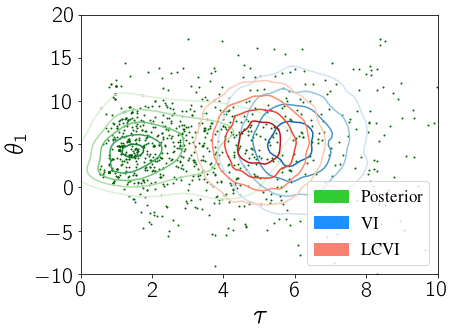

In [47]:
nsamples = 50000
theta_no = 1
n_levels = 4

start_plotting(font_size=17*1.5, left=0.175)
label_patches = []

x, y = (fit.extract()["tau"]), fit.extract()["theta"][:,theta_no]
sns.kdeplot(x, y, n_levels=int(n_levels*1.3), shade=False, cmap="Greens");
label_patches.append(mpatches.Patch(color="limegreen",label="Posterior")) #sns.color_palette("Greens")[2]
plt.scatter(x, y, s=1, color="darkgreen")

tau = np.array([softplus(q_tau_vi.sample()).item() for _ in range(nsamples)])
theta = np.array([q_theta_vi.sample()[theta_no].item() for _ in range(nsamples)])
sns.kdeplot(tau, theta, n_levels=n_levels, shade=False, cmap="Blues")
label_patches.append(mpatches.Patch(color="dodgerblue",label="VI")) #sns.color_palette("Blues")[2]

tau = np.array([softplus(q_tau_lcvi.sample()).item() for _ in range(nsamples)])
theta = np.array([q_theta_lcvi.sample()[theta_no].item() for _ in range(nsamples)])
sns.kdeplot(tau, theta, n_levels=n_levels, shade=False, cmap="Reds")
label_patches.append(mpatches.Patch(color="salmon",label="LCVI")) #sns.color_palette("Reds")[2]

plt.xlabel(r"$\tau$");plt.ylabel(r"$\theta_%i$" % theta_no); #plt.legend();
plt.legend(handles=label_patches, loc='lower right', fontsize=17);
plt.grid(False); plt.xlim((0, 10)); plt.ylim((-10,20));

plt.savefig("8schools_tau_theta_fits.pdf");
plt.show();

### Full overview

In [48]:
_t = lambda d: list(np.array(d)[-1,]) if np.array(d)[-1,].shape!=() else [np.array(d)[-1,]]

locs_vi = _t(trajectory_vi["qmu_loc"])+_t(trajectory_vi["qtau_loc"])+\
          _t(trajectory_vi["qtheta_loc"])
scales_vi = _t(trajectory_vi["qmu_scale"])+_t(trajectory_vi["qtau_scale"])+\
            _t(trajectory_vi["qtheta_scale"])

locs_lcvi = _t(trajectory_lcvi["qmu_loc"])+_t(trajectory_lcvi["qtau_loc"])+\
            _t(trajectory_lcvi["qtheta_loc"])
scales_lcvi = _t(trajectory_lcvi["qmu_scale"])+_t(trajectory_lcvi["qtau_scale"])+\
              _t(trajectory_lcvi["qtheta_scale"])

locs_lcviem = _t(trajectory_lcviem["qmu_loc"])+_t(trajectory_lcviem["qtau_loc"])+\
              _t(trajectory_lcviem["qtheta_loc"])
scales_lcviem = _t(trajectory_lcviem["qmu_scale"])+_t(trajectory_lcviem["qtau_scale"])+\
                _t(trajectory_lcviem["qtheta_scale"])

locs_true = [fit.extract()["mu"].mean(), fit.extract()["tau"].mean()]+\
            [fit.extract()["theta"][:,i].mean() for i in range(8)]
scales_true = [fit.extract()["mu"].std(), fit.extract()["tau"].std()]+\
              [fit.extract()["theta"][:,i].std() for i in range(8)]

names = [r"$\mu$", r"$\tau$"] + [(r"$\theta_%i$" % i) for i in range(1,9)]

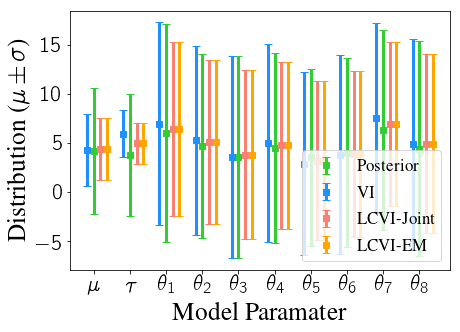

In [49]:
start_plotting(font_size=17*1.5)

x = np.array(range(len(locs_vi)))*1.25
offset = 0.23

plt.errorbar(x, locs_true, yerr=np.array(scales_true)*2, label="Posterior",
             fmt='-s', lw=0, color=GREEN, ecolor=GREEN, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

plt.errorbar(x-offset, locs_vi, yerr=np.array(scales_vi)*2, label="VI",
             fmt='-s', lw=0, color=BLUE, ecolor=BLUE, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

plt.errorbar(x+offset, locs_lcvi, yerr=np.array(scales_lcvi)*2, label="LCVI-Joint",
             fmt='-s', lw=0, color=RED, ecolor=RED, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

plt.errorbar(x+2*offset, locs_lcviem, yerr=np.array(scales_lcviem)*2, label="LCVI-EM",
             fmt='-s', lw=0, color="orange", ecolor="orange", elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

plt.xticks(x, names)
plt.ylabel("Distribution ($\mu  \pm \sigma$)")
plt.xlabel("Model Paramater")
plt.legend(loc=4,fontsize=17)

plt.show();

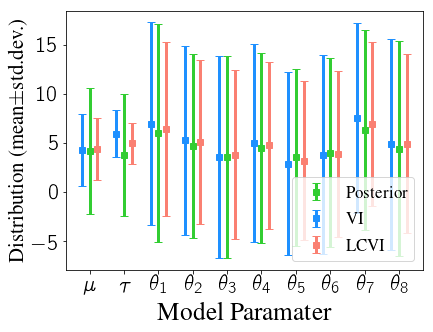

In [50]:
start_plotting(font_size=17*1.5, left=0.175)

x = np.array(range(len(locs_vi)))*1.25
offset = 0.28

plt.errorbar(x, locs_true, yerr=np.array(scales_true)*2, label="Posterior",
             fmt='-s', lw=0, color=GREEN, ecolor=GREEN, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

plt.errorbar(x-offset, locs_vi, yerr=np.array(scales_vi)*2, label="VI",
             fmt='-s', lw=0, color=BLUE, ecolor=BLUE, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

plt.errorbar(x+offset, locs_lcvi, yerr=np.array(scales_lcvi)*2, label="LCVI",
             fmt='-s', lw=0, color=RED, ecolor=RED, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)


plt.xticks(x, names)
plt.ylabel("Distribution (mean$\pm$std.dev.)", fontsize=21)
plt.xlabel("Model Paramater")
plt.legend(loc=4,fontsize=17)

plt.savefig("8schools_all_fits.pdf")
plt.show();

## Predictive posteriors

In [51]:
def sample_predictive_y0_HMC(data, theta, nsamples_y=100):
    sigma = torch.tensor(data["sigma"], dtype=torch.float32)        
    ys = Normal(theta, sigma).rsample(torch.Size([nsamples_y]))    
    return ys


def sample_predictive_y_HMC(data, theta, nsamples_y=100):
    ys = sample_predictive_y0_HMC(data, theta, nsamples_y)
    return flatten_first_two_dims(ys)

In [52]:
ys_true = sample_predictive_y_HMC(schools_dat, torch.tensor(fit.extract()["theta"], dtype=torch.float32), 500)
ys_vi = sample_predictive_y(schools_dat, q_theta_vi, 1000, 500)
ys_lcvi = sample_predictive_y(schools_dat, q_theta_lcvi, 1000, 500)
ys_lcviem = sample_predictive_y(schools_dat, q_theta_lcviem, 1000, 500)

y_true_locs, y_true_scales, y_true_h = [], [], []
y_vi_locs, y_vi_scales, y_vi_h = [], [], []
y_lcvi_locs, y_lcvi_scales, y_lcvi_h = [], [], []
y_lcviem_locs, y_lcviem_scales, y_lcviem_h = [], [], []

names = []
for j in range(8):
    names.append(r"$y_%i$" % (j+1))
    
    y_true_locs.append(ys_true[:,j].mean().item())
    y_true_scales.append(ys_true[:,j].std().item())    
    y_true_h.append(optimal_h(ys_true[:,j]).item())
    
    y_vi_locs.append(ys_vi[:,j].mean().item())
    y_vi_scales.append(ys_vi[:,j].std().item())    
    y_vi_h.append(optimal_h(ys_vi[:,j]).item())    
    
    y_lcvi_locs.append(ys_lcvi[:,j].mean().item())
    y_lcvi_scales.append(ys_lcvi[:,j].std().item())
    y_lcvi_h.append(optimal_h(ys_lcvi[:,j]).item())
    
    y_lcviem_locs.append(ys_lcviem[:,j].mean().item())
    y_lcviem_scales.append(ys_lcviem[:,j].std().item())
    y_lcviem_h.append(optimal_h(ys_lcviem[:,j]).item())    

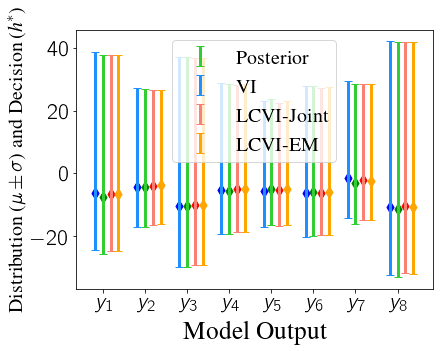

In [53]:
start_plotting(font_size=17*1.5, left=0.175)

x = np.array(range(len(y_vi_locs)))*1.25
offset = 0.23

plt.errorbar(x, y_true_locs, yerr=np.array(y_true_scales)*2, label="Posterior",
             fmt='-', lw=0, color=GREEN, ecolor=GREEN, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)
plt.scatter(x, y_true_h, color="green", marker="d", s=70)

plt.errorbar(x-offset, y_vi_locs, yerr=np.array(y_vi_scales)*2, label="VI",
             fmt='-', lw=0, color=BLUE, ecolor=BLUE, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)
plt.scatter(x-offset, y_vi_h, color="blue", marker="d", s=70)

plt.errorbar(x+offset, y_lcvi_locs, yerr=np.array(y_lcvi_scales)*2, label="LCVI-Joint",
             fmt='-', lw=0, color=RED, ecolor=RED, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)
plt.scatter(x+offset, y_lcvi_h, color="red", marker="d", s=70)

plt.errorbar(x+2*offset, y_lcviem_locs, yerr=np.array(y_lcviem_scales)*2, label="LCVI-EM",
             fmt='-', lw=0, color="orange", ecolor="orange", elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)
plt.scatter(x+2*offset, y_lcviem_h, color="orange", marker="d", s=70)

plt.xticks(x, names)
plt.ylabel(r"Distribution ($\mu  \pm \sigma$) and Decision ($\textit{h}^*$)", fontsize=20)
plt.xlabel("Model Output")
plt.legend(fontsize=20);

plt.savefig("8schools_y_fits.pdf")
plt.show();

### Sample predictive posterior

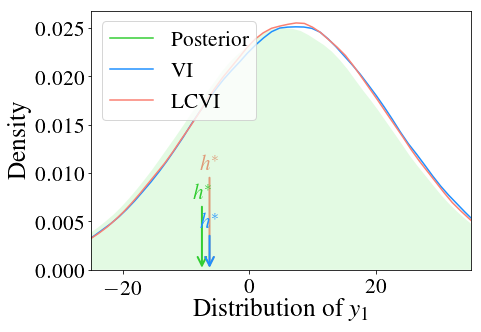

In [54]:
j = 0 # output to plot; j \in [0..7]

def _plot_output(j, posy=0.006): 
    torch.manual_seed(123)
    
    ys_true = sample_predictive_y_HMC(schools_dat, torch.tensor(fit.extract()["theta"], dtype=torch.float32), 500)
    h = optimal_h(ys_true)
    plt.plot([-100,-99],[0,0], color=GREEN, label='Posterior') #add to legend 
    sns.kdeplot(tonumpy(ys_true[:,j]), color="lightgreen", shade=True, lw=0, alpha=0.25)
    #plt.axvline(h[j], color=BLUE)
    plt.annotate("$h^{*}$", xy=(h[j], 0.0), xytext=(h[j], 1.5*posy), 
                 arrowprops=dict(arrowstyle="->", color=GREEN, lw=2), 
                 horizontalalignment='center', verticalalignment='top', color=GREEN, zorder=3)

    ys_vi = sample_predictive_y(schools_dat, q_theta_vi, 1000, 500)
    h = optimal_h(ys_vi)
    sns.kdeplot(tonumpy(ys_vi[:,j]), label="VI", color=BLUE, shade=False)
    #plt.axvline(h[j], color=BLUE)
    plt.annotate("$h^{*}$", xy=(h[j], 0.0), xytext=(h[j], 1*posy), 
                 arrowprops=dict(arrowstyle="->", color=BLUE, lw=2), 
                 horizontalalignment='center', verticalalignment='top', color=BLUE)

    ys_lcvi = sample_predictive_y(schools_dat, q_theta_lcvi, 1000, 500)
    h = optimal_h(ys_lcvi)
    sns.kdeplot(tonumpy(ys_lcvi[:,j]), label="LCVI", color=RED, shade=False)
    #plt.axvline(h[j], color=RED)
    plt.annotate("$h^{*}$", xy=(h[j], 0.0), xytext=(h[j], 2*posy), 
                 arrowprops=dict(arrowstyle="->", color=RED, lw=2), 
                 horizontalalignment='center', verticalalignment='top', color=RED, zorder=-3)

start_plotting(cmbright=False, font_size=17*1.5)
ax1=plt.gca()
plt.sca(ax1)
_plot_output(j)    
plt.xlim(-25, 35)
plt.xlabel(r"Distribution of $y_%i$" % (j+1));
plt.ylabel("Density");
plt.legend(loc=2)

plt.savefig("8schools_y_fit_comparison.pdf");
plt.show();